In [1]:
%matplotlib inline

import warnings
warnings.simplefilter('ignore')
import xarray as xr
import numpy as np
import cmocean.cm as cmo
import matplotlib.pyplot as plt
from dask.diagnostics import ProgressBar

plt.style.use('ggplot')

# MARTINI: Chl-a indicators

This notebook tests a preliminary netCDF processing workflow for the MARTINI "indicators". Note that working via Thredds incurs a significant performance penalty - see below for details.

Ciarán already has summary netCDF output produced on Fram. We want to modify this workflow slightly, but first I want to check that I can re-create Ciarán's results using the data on Thredds. An example of the Fram output for total Chl-a (`light_Chl`) can be found here for comparison:

    shared/martini/martini800_v2_Chl_surf.nc
    
Note that this uses only data from the **surface layer**. In the new workflow, we actually want the **average concentration over the upper 10 m**.

## 1. Read data from Thredds

### 1.1. Dataset properties

The code below prints a summary of the entire dataset, which is nearly a terabyte in size. To work with this efficiently (and to avoid network timeout issues on Thredds) we will need to use "chunking". Even so, working with this much data via Thredds will be slow, since calculations cannot be performed on the Thredds server itself. Any calculations involving significant subsets of the whole dataset will therefore require transferring 10s or 100s of GB of data over a network connection, which is inefficent.

As shown below, the dataset has dimensions `(time, x, y, z)` of `(364, 480, 426, 42)`. Most variables of interest are stored as 32 bit (= 4 byte) floats, and there are 6 variables involved in the calculation of `light_Chl` (`P1_Chl` to `P6_Chl`). Some useful numbers to keep in mind:

 * A single horizontal layer for a single variable at a single time step is ~0.8 MB
 
 * A single horizontal layer for a single variable for all time steps is ~298 MB
 
 * A single variable for all layers and time steps is ~12.5 GB
 
 * All 6 variables for all layers and time steps is ~75 GB

In [3]:
# Open dataset and print metadata summary
ncml_path = r'http://thredds.met.no/thredds/dodsC/metusers/arildb/MARTINI800_prov_v2.ncml' 
ds = xr.open_dataset(ncml_path, chunks={})

print(f'Total dataset size: {ds.nbytes/1E9:.2f} GB.')

ds

Total dataset size: 928.87 GB.


<xarray.Dataset>
Dimensions:         (boundary: 4, eta_psi: 425, eta_rho: 426, eta_u: 426, eta_v: 425, ocean_time: 364, s_rho: 42, s_w: 43, tracer: 66, xi_psi: 479, xi_rho: 480, xi_u: 479, xi_v: 480)
Coordinates:
  * s_rho           (s_rho) float64 -0.9881 -0.9643 -0.9405 ... -0.03571 -0.0119
  * s_w             (s_w) float64 -1.0 -0.9762 -0.9524 ... -0.04762 -0.02381 0.0
    lon_rho         (eta_rho, xi_rho) float64 dask.array<shape=(426, 480), chunksize=(426, 480)>
    lat_rho         (eta_rho, xi_rho) float64 dask.array<shape=(426, 480), chunksize=(426, 480)>
    lon_u           (eta_u, xi_u) float64 dask.array<shape=(426, 479), chunksize=(426, 479)>
    lat_u           (eta_u, xi_u) float64 dask.array<shape=(426, 479), chunksize=(426, 479)>
    lon_v           (eta_v, xi_v) float64 dask.array<shape=(425, 480), chunksize=(425, 480)>
    lat_v           (eta_v, xi_v) float64 dask.array<shape=(425, 480), chunksize=(425, 480)>
    lon_psi         (eta_psi, xi_psi) float64 dask.array<sh

## 2. Re-create Ciarán's original workflow

### 2.1. Computation graphs

The code below focuses on just the surface layer. As a starting point, we want to sum the variables `P1_Chl` to `P6_Chl`.

In [4]:
# Check units are compatible for all components
for var_name in ['P1_Chl', 'P2_Chl', 'P3_Chl', 'P4_Chl', 'P5_Chl', 'P6_Chl']:
    print (ds[var_name].attrs['units'])

mg/m^3
mg/m^3
mg/m^3
mg/m^3
mg/m^3
mg/m^3


In [5]:
# Just the surface layer
ds = ds.isel(s_rho=-1)

# Sum vars
ds['light_Chl'] = ds['P1_Chl'] + ds['P2_Chl'] + ds['P3_Chl'] + ds['P4_Chl'] + ds['P5_Chl'] + ds['P6_Chl']

# Get just var of interest
ds = ds['light_Chl']

print(f'Total size: {ds.nbytes/1E9:.3f} GB.')

# Show dataset structure in memory
ds.data

Total size: 0.298 GB.


dask.array<add, shape=(364, 426, 480), dtype=float32, chunksize=(364, 426, 480)>

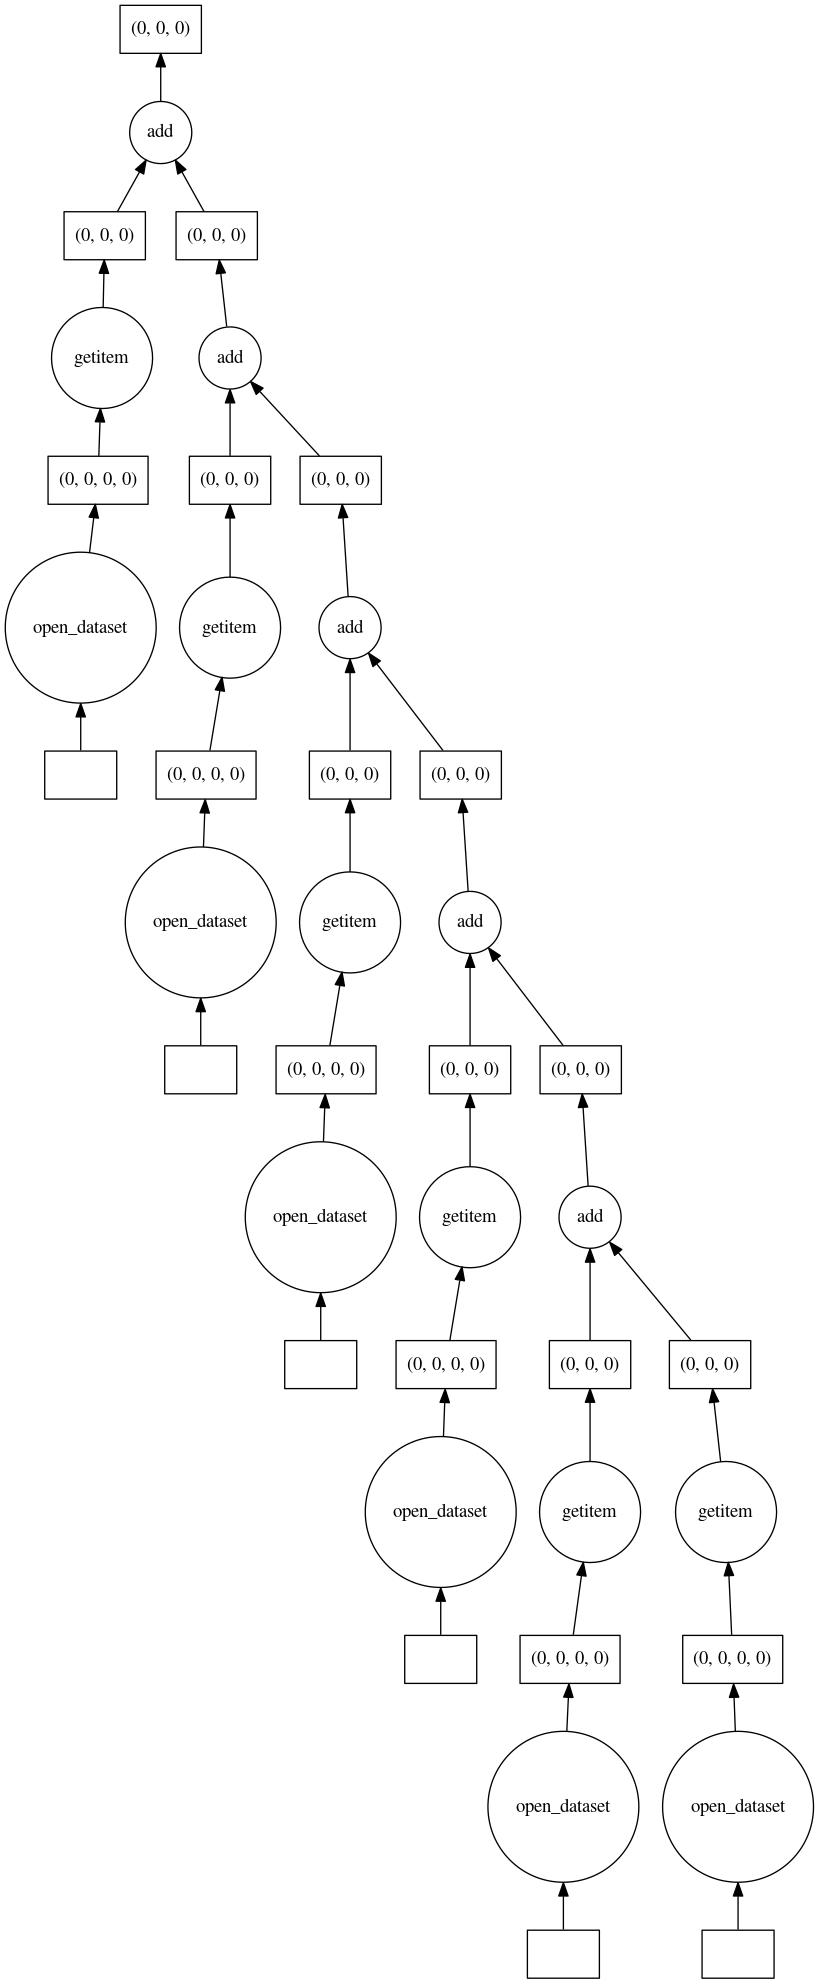

In [6]:
# Visualise the task graph
ds.data.visualize()

The "task graph" shows what the computation looks like for processing the surface dataset in a single "chunk". The final dataset size agrees with my back-of-the-envelope estimate from above (298 MB). This is reassuring, but this naive approach is likely to encounter problems with network timeout issues on Thredds, since each of the 6 datasets is opened in a single 298 MB slice.

## 2. Re-create Ciarán's original workflow

### 2.1. "Chunking" the surface-only workflow

The code below focuses on just the surface layer. Based on the rough calculations above, each time step for each variable at the surface will be 0.8 MB, and I need to query 6 layers simultaneously for the calculation of `light_Chl`, which gives about 5 MB per time step. Chunking 10 time steps at a time therefore gives requests to Thredds of about 50 MB, which seems reasonable.

**Updated 10.09.2019:** It seems xarray has and `auto` option for chunking. The behaviour of this is not well documented, and it doesn't do much better than my rough estimate from above. However, using `auto` is simpler and slightly faster, so I'll switch to this for now.

In [7]:
# Read again using chunking
ds = xr.open_dataset(ncml_path,
                     chunks={
                             'ocean_time':'auto',  # Was 10
                            # 's_rho':1,
                            # 'eta_rho':200,
                            # 'xi_rho':200,
                            },
                    )

# Just the surface layer
ds = ds.isel(s_rho=-1)

### 2.2. Calculate `light_Chl`

In [8]:
# Sum vars
ds['light_Chl'] = ds['P1_Chl'] + ds['P2_Chl'] + ds['P3_Chl'] + ds['P4_Chl'] + ds['P5_Chl'] + ds['P6_Chl']

# Get just var of interest
ds = ds['light_Chl']

print(f'Total size: {ds.nbytes/1E9:.3f} GB.')

# Show dataset structure in memory
ds.data

Total size: 0.298 GB.


,Array,Chunk
Bytes,297.72 MB,1.64 MB
Shape,"(364, 426, 480)","(2, 426, 480)"
Count,3100 Tasks,182 Chunks
Type,float32,numpy.ndarray


Using `auto` has divided the dataset every two time-steps (instead of 10), creating five times more chunks than my initial estimate. This produces a very complicated task graph (not shown here).

So far, all evaluations have been performed "lazily". The code below saves the result as a new netCDF, which triggers all the computations specified so far. This step takes a while, as roughly 1.8 GB of data need to be downloaded from Thredds.

In [9]:
# Save
with ProgressBar():
    out_nc_path = r'../../../../shared/martini/light_chl_surf_test.nc'
    ds.to_netcdf(out_nc_path)

[########################################] | 100% Completed |  6min 31.2s


### 2.3. Compare to Fram output

The code below reads the netCDF created above and compares it to Ciarán's output from Fram (for a user-specified time step).

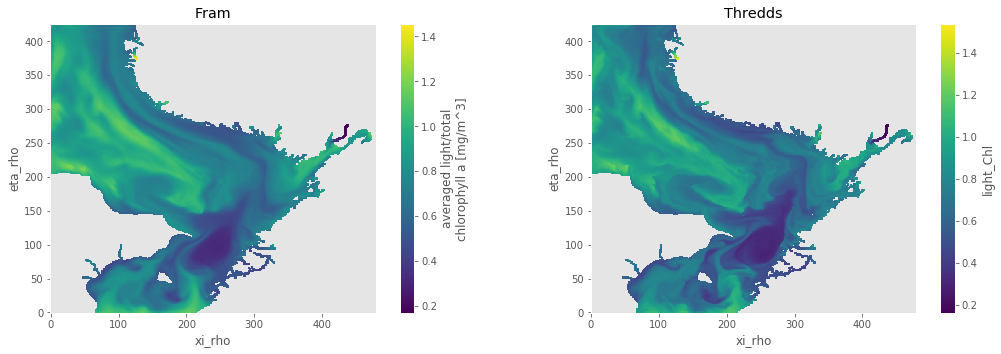

In [10]:
# Date index of interest
dt_idx = 180

# Use to adjust colourbar scale. Set to None to use full range of data
# on each subplot
vmin, vmax = None, None

# Read data
orig_nc_path = r'../../../../shared/martini/martini800_v2_Chl_surf.nc'
out_nc_path = r'../../../../shared/martini/light_chl_surf_test.nc'
orig_ds = xr.open_dataset(orig_nc_path)
test_ds = xr.open_dataset(out_nc_path)

# Plot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
for ax in axes:
    ax.set_aspect('equal')
    
orig_ds['light_Chl'].isel(ocean_time=dt_idx).plot(ax=axes[0], vmin=vmin, vmax=vmax)
test_ds['light_Chl'].isel(ocean_time=dt_idx).plot(ax=axes[1], vmin=vmin, vmax=vmax)

axes[0].set_title('Fram')
axes[1].set_title('Thredds')

plt.tight_layout()

These maps are similar, but not the same - need to **check with Ciarán that the calculation above is correct**.

## 3. Average over top 10 m

The simple approach to averaging over the top 10 m involves downloading data for all depth layers. This will increase the size of each Thredds request by a factor of 42, which is a bit large. Changing the "chunking" to consider one time step and 10 depth layers at a time should keep the overall request size similar to the example above (i.e. about 50 MB).

I'm not sure how sophisticated Thredds can be at slicing datasets. Maybe it'll only extract the layers necessary for < 10 m depth, in which case processing times might be manageable. If not, the data transfer time should increase by a factor of ~42, plus some additional overhead for the increased chunking (not to mention the actual processing). The example above took 8.5 minutes, so I'd expect this to take around **6 hours just for the data download**.

**Updated 10.09.2019:** I'll give this a go using `auto` chunking for both depth and time.

In [11]:
# Read again using chunking
ds = xr.open_dataset(ncml_path,
                     chunks={
                             'ocean_time':'auto',
                             's_rho':'auto',
                            # 'eta_rho':200,
                            # 'xi_rho':200,
                            },
                    )

### 3.1. Check distribution of depths

In [12]:
# Check how depths are distributed
np.diff(ds['s_rho'])

array([0.02380952, 0.02380952, 0.02380952, 0.02380952, 0.02380952,
       0.02380952, 0.02380952, 0.02380952, 0.02380952, 0.02380952,
       0.02380952, 0.02380952, 0.02380952, 0.02380952, 0.02380952,
       0.02380952, 0.02380952, 0.02380952, 0.02380952, 0.02380952,
       0.02380952, 0.02380952, 0.02380952, 0.02380952, 0.02380952,
       0.02380952, 0.02380952, 0.02380952, 0.02380952, 0.02380952,
       0.02380952, 0.02380952, 0.02380952, 0.02380952, 0.02380952,
       0.02380952, 0.02380952, 0.02380952, 0.02380952, 0.02380952,
       0.02380952])

It looks as though depths are always distributed evenly i.e. each layer is a fixed proportion of the total depth.

### 3.2. Calculate total Chl-a

Need to sum the different components of chl-a, as above.

In [13]:
# Sum vars
ds['light_Chl'] = ds['P1_Chl'] + ds['P2_Chl'] + ds['P3_Chl'] + ds['P4_Chl'] + ds['P5_Chl'] + ds['P6_Chl']

### 3.3. Mean total chl-a concentration in top 10 m

We're interested in the mean chl-a concentration in the upper 10 m of the water column. Because the layers are evenly spaced, each has equal weight so we can just take the mean of all layers at <10 m depth.

In [14]:
# Average depths < 10 m
ds = ds['light_Chl'].where(ds['h']*ds['s_rho'] > -10).mean(dim='s_rho')
print(f'Total size: {ds.nbytes/1E9:.3f} GB.')
ds

Total size: 0.298 GB.


<xarray.DataArray 'light_Chl' (ocean_time: 364, eta_rho: 426, xi_rho: 480)>
dask.array<shape=(364, 426, 480), dtype=float32, chunksize=(7, 426, 480)>
Coordinates:
    lon_rho     (eta_rho, xi_rho) float64 dask.array<shape=(426, 480), chunksize=(426, 480)>
    lat_rho     (eta_rho, xi_rho) float64 dask.array<shape=(426, 480), chunksize=(426, 480)>
  * ocean_time  (ocean_time) datetime64[ns] 2017-01-02 2017-01-03 ... 2017-12-31
Dimensions without coordinates: eta_rho, xi_rho

In [15]:
# Show data structure in memory
ds.data

,Array,Chunk
Bytes,297.72 MB,5.73 MB
Shape,"(364, 426, 480)","(7, 426, 480)"
Count,4239 Tasks,52 Chunks
Type,float32,numpy.ndarray


In [16]:
# Save
with ProgressBar():
    out_nc_path = r'../../../../shared/martini/light_chl_upper_10m_test.nc'
    ds.to_netcdf(out_nc_path)

[########################################] | 100% Completed | 59min 37.5s
